# Introduction to Phytoplankton Photophysiology Utilities 

Welcome to the interactive tutorial on processing active chlorophyll fluorescence data.

Below is a rough guide on how the [PhytoPhotoUtils](https://gitlab.com/tjryankeogh/phytophotoutils) package works.  

1. Importing the package.
2. Loading Data
3. Pre-processing corrections
        3.1 Average Raw Data
4. Perform fitting routines
        4.1 Saturation
        4.2 Relaxation
5. Post-processing corrections
        5.1 Blanks
        5.2 LED Spectral Correction

**Extras:** 

FLC Processing

### PhytoPhotoUtils Package Overview 

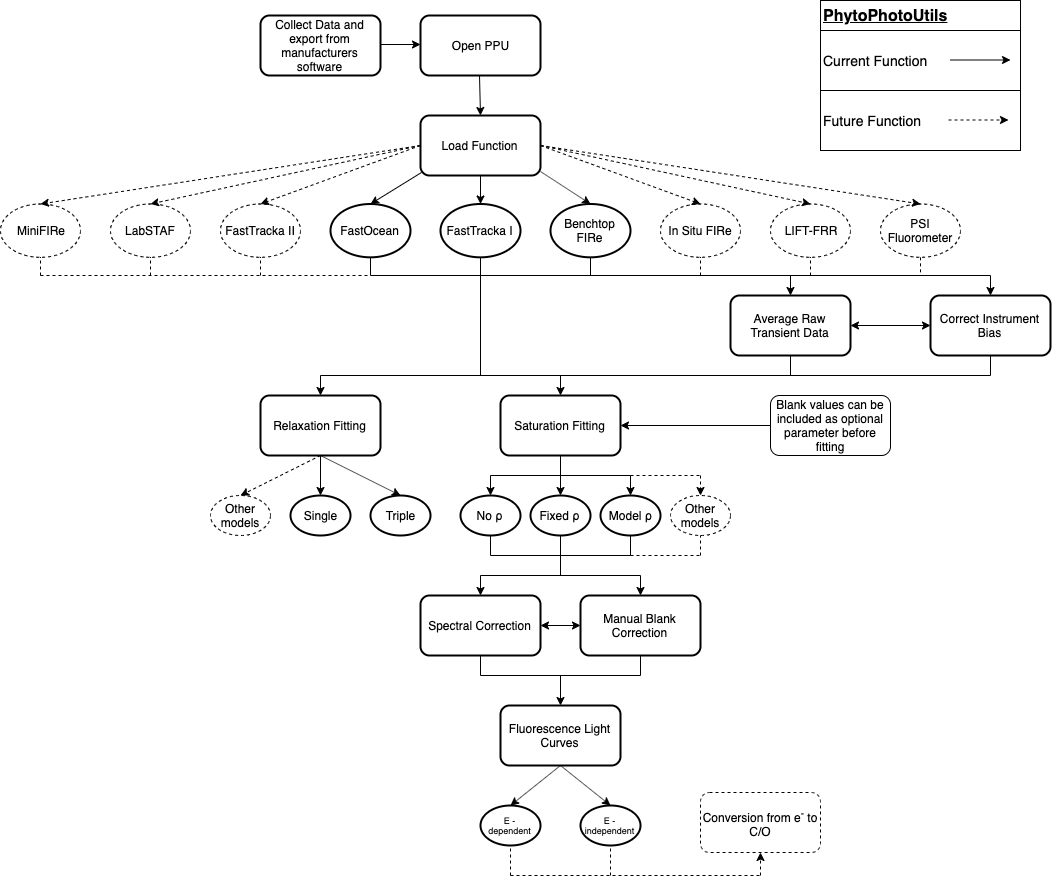

The package installation requires the following [SciPy](https://www.scipy.org/) core packages:

1. [NumPy](https://www.numpy.org/)
2. [Pandas](https://pandas.pydata.org/)

Additional packages include:
</div>

- [tqdm](https://tqdm.github.io/)
<br>

## 1. Importing the package

In [ ]:
import sys
import os
sys.path.append('..')
import phyto_photo_utils as ppu
import pandas as pd
%pylab inline

## 2. The `load` Function

The current functionality is designed around the data structure of 3 instruments:

1. Benchtop FIRe
2. FastTracka I
3. FastOcean

The loading functions require the following inputs:

- file: the path directory to the raw files  
  [`dir`]
- append: if True, multiple files will be concatenated together  
  [`bool`]
- save_files: if True, files will be saved as .csv  
  [`bool`] 
- res_path: the path directory where to save files, only required if save_files = True  
  [`numpy.array`]
- seq_len: the number of flashlets in the protocol  
  [`int`]
- flen: the flashlet length in seconds  
  [`int`]
- irrad: the LED output - not required for `load_FastOcean_files`   
  [`int`]


The following is only applicable for `load_FastOcean_files`:
- led_separate: if True, the LED protocols will be separated dependent upon the LED sequence  
  [`bool`]

Future versions of the code will take into account additional instrumentation, and perhaps more easily accessible exported data formats.

Additionally, for older instruments users need to know the LED output on the instrument, whereas newer instruments have this built into the raw data output.

**Example Usage**

In [ ]:
# path directory to the raw instrument file
fname = './data/raw/instrument/fasttrackai/FASTTrackaI_example.csv'

# path directory where unprocessed raw data will be stored
output = './data/raw/ppu/fasttrackai/'

# converts raw instrument file to raw ppu file
df = ppu.load_FASTTrackaI_files(fname, append=False, save_files=True, res_path=output, seq_len=120, irrad=545.62e10)

df.head()

#### Benchtop FIRe

Following the example above, load the example data file from a benchtop FIRe instrument.  We want to save the files into the specified output directory.

Parameters:  
Sequence length = 160  
Flashlet length = 1e$^{-6}$  
Irradiance = 47248 μmol photons m$^{-2}$ s$^{-1}$  

In [ ]:
fname = './data/raw/instrument/fire/FIRe_example.000'
output = './data/raw/ppu/fire/'
df_fire = ppu.load_FIRe_files()
df_fire.head()

#### FastOcean 
Following the example above, load the example data file from a FastOcean instrument. We want to save the files and separate the files based upon the LED measurement sequence.

Parameters:  
Sequence length = 140  
Flashlet length = 1e$^{-6}$  

In [ ]:
fname = './data/raw/instrument/fastocean/FastOcean_example.csv'
output = './data/raw/ppu/fastocean/'
df_fastocean = ppu.load_FastOcean_files(fname)
df_fastocean.head()

If you are processing many files at once with the use of file lists, then all loading functions have the option of appending to output together into a single `DataFrame`.

## 3. Pre-fitting corrections 

### 3.1 Averaging Raw Transients

In order to improve the signal to noise ratio in low biomass systems, the raw transient data should be averaged together.

The following function, `remove_outlier_from_time_average`, is designed to average data within a user defined time window, whilst excluding potential outliers using $\bar{x}$ ± ($\sigma$ x m) (where m is user defined).


The function requires the following inputs:

- df: a `pandas.DataFrame` of the raw data, can either be imported from pandas.read_csv or the output from phyto_photo_utils.load   
  [`pandas.DataFrame`]
- time: the time window to average over, e.g. 4 = 4 minute average  
  [`int`]
- multiplier: the multiplier to apply to the standard deviation for determining the upper and lower limits  
  [`int`] 

**Note**

The current functionality is only designed for data collected in underway mode where it uses the instrument time stamp to create averaging windows.

Users must be aware of what their current sampling frequency. See example below.

In [ ]:
dt = diff(unique(df.datetime))
dt[0]

35 x 10$^{9}$ nanoseconds = 35 seconds

So we can use this function to create a mean over a larger time window, i.e. 2 minutes.

In [ ]:
df2  = ppu.remove_outlier_from_time_average(df, time=2, multiplier=3)
dt = diff(unique(df2.datetime))
dt[0]

12 x 10$^{10}$ nanoseconds = 120 seconds 

<img style="float: left; width: 500px;" src="./img/FastTrackaI_time_averaging_example.png"/>

Figure: (a) Raw fluorescence yield data with the limits defined by $\bar{x}$ ± ($\sigma$ x m), outliers fall outside these limits. (b) $\bar{x}$ & $\sigma$ of the new time averaged fluorescence yield data.

## 4. The `saturation` function 

The saturation fitting function offers the user three options to fit the biophysical model of Kolber et al. (1998):

1. Calculate with no connectivity coefficient: no_ro = True

    f$_n$  = f$_o$ + (f$_m$ - f$_o$) $\times$ (1 - e$^{(-σ \times ∑(pfd))}$) 
    
    
2. Calculate with connectivity coefficient

    f(t) = f$_o$ + (f$_m$ - f$_o$) $\times$ C(t)$\frac{1 - ρ}{1 - C(t)ρ}$ 
    
    $\frac{dC(t)}{dt}$ = i(t) σ$_{PSII}$ $\frac{1 - C(t)}{1 - C(t)ρ}$ - $\frac{C(t)}{τ}$
    

3. Calculate with fixed connectivity coefficient: fixed_ro = True

The function requires the following inputs:

- pfd: the photon flux density of the instrument calculated using the load function  
  [`numpy.array`]
- fyield: the fluorescence yield of the instrument  
  [`numpy.array`]
- seq: the measurement number  
  [`numpy.array`] 
- datetime: the date & time of each measurement in the `numpy.datetime64` format  
  [`numpy.array`]
- blank: the blank value, if `numpy.array` must be the same length as fyield  
  [`float`, `int` or `numpy.array`]
- sat_len: the number of flashlets in the saturation sequence  
  [`int`]
- skip: the number of flashlets to skip at the start  
  [`int`]
- ro: the fixed value of the connectivity coefficient. Not required if fixed_ro is False.  
[`float`]  
- no_ro : if True, this processes the raw transient data and performs the no connectivity saturation model.  
[`bool`]
- fixed_ro : if True, this sets a user defined fixed value for ro (the connectivity factor) when fitting the saturation model.  
[`bool`] . 
- bounds: if True, will set lower and upper limit bounds for the estimation, 
  not suitable for methods `lm`  
  [`bool`]
- sig_lims: the lower and upper limit bounds for fitting sigmaPSII  
  [`int`, `int`]
- ro_lims: the lower and upper limit bounds for fitting the connectivity coefficient. Not required if no_ro and fixed_ro are False.  
  [`float`, `float`]

The following options control the parameters of the least_squares fitting. They are derived from the `scipy.optimize.least_squares` function.

- method: The algorithm to perform minimization  
[`str`]
- loss: The loss function to be used. Note: Method ‘lm’ supports only ‘linear’ loss  
[`str`]
- f_scale: The soft margin value between inlier and outlier residuals  
[`float`]
- max_nfev: The number of iterations to perform fitting routine  
[`int`]
- xtol: The tolerance for termination by the change of the independent variables  
[`float`]

See [scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) documentation for more information on non-linear least squares fitting options.



### 4.1 Calculate ρ model

In [ ]:
# read in raw file generated from the load function
df = pd.read_csv('./data/raw/ppu/fasttrackai/FASTTrackaI_example.csv', index_col=0)

# perform the fitting routine where p is modelled
sat = ppu.fit_saturation(df.pfd, df.fyield, df.seq, df.datetime, blank=0, sat_len=100, 
                                 skip=0, no_ro=False, fixed_ro=False, sig_lims =[100,2000])

# save the fit results in the output folder
#output = './data/output/saturation/calc_p/'
#sat.to_csv(output+'FASTTrackaI_sat_calc_p.csv')

In [ ]:
sat.head()

### Plotting the data

The package offers the user a very simple tool to quickly plot the data.
It requires the following inputs:

- fyield: the raw fluorescence yield data  
[`array`]
- pfd: the photon flux density  
[`array`]
- fo: the minimum fluorescence level  
[`float`]
- fm: the maximum fluorescence level  
[`float`]
- sigma: the effective absorption cross-section of PSII  
[`float`]
- ro: the connectivity coefficient  
[`float`]
- rmse: the RMSE value of the fit  
[`float`]

The function will return a `matplotlib.figure` object.


In [ ]:
ppu.plot_saturation_data(df.fyield[0:100], df.pfd[0:100], fo=sat.fo[0], 
                         fm=sat.fm[0], sigma=sat.sigma[0], ro=sat.ro[0], rmse=sat.rmse[0])


### 4.2 Fixed ρ model 

Exercise:

Calculate the saturation results using the example FIRe data and the fixed ρ model.

Blank = 0  
Saturation length = 100  
Skip = 1

In [ ]:
df = pd.read_csv('./data/raw/ppu/fire/FIRe_example.csv', index_col=0)

## Fill in the required arguments
sat = ppu.fit_saturation()

# This will save the data for future use
output = './data/output/saturation/fixed_p/'
sat.to_csv(output+'FIRe_sat_fixed_p.csv')
sat.head()

### 4.3 No ρ model

Exercise:

Calculate the saturation results using the FastOcean data and the no ρ model.

Saturation length = 100

In [ ]:
df = pd.read_csv('./data/raw/ppu/fastocean/FastOcean_example.csv', index_col=0)

# Fill in the required arguments
sat = ppu.fit_saturation()

# This will save the data for future use
output = './data/output/saturation/no_p/'
sat.to_csv(output+'FastOcean_sat_no_p.csv')
sat.head()

## 5. The `relaxation` function

The relaxation fitting function offers the user two options:

1. Calculate a single fluorescence decay: single_decay = True
2. Calculate a triple fluorescence decay: single_decay = False

The function requires the following inputs:

- seq_time: the sequence time of the flashlets  
  [`numpy.array`]
- fyield: the fluorescence yield of the instrument  
  [`numpy.array`]
- seq: the measurement number  
  [`numpy.array`] 
- datetime: the date & time of each measurement in the numpy datetime64 format  
  [`numpy.array`]
- blank: the blank value, if np.array must be the same length as fyield  
  [`float`, `int` or `numpy.array`]
- sat_len: the number of flashlets in the saturation sequence  
  [`int`]
- rel_len: the number of flashlets in the relaxation sequence  
  [`int`]
- sat_flashlets: the number of saturation flashlets to include at the start  
  [`int`]
- single_decay: If True, will fit a single decay relaxation  
[`bool`]
- bounds: if True, will set lower and upper limit bounds for the estimation, 
  not suitable for methods `lm`  
  [`bool`]
- single_lims: the lower and upper limit bounds for fitting a single decay tau  
  [`int`, `int`]

The following are only applicable if single_decay is False:
- tau1_lims: the lower and upper limit bounds for fitting tau1  
  [`float`, `float`]
- tau2_lims: the lower and upper limit bounds for fitting tau2  
  [`float`, `float`]
- tau3_lims: the lower and upper limit bounds for fitting tau3  
  [`float`, `float`]
  
The following options control the parameters of the least_squares fitting. They are derived from the `scipy.optimize.least_squares` function.

- method: The algorithm to perform minimization  
[`str`]
- loss: The loss function to be used. Note: Method `lm` supports only `linear` loss  
[`str`]
- f_scale: The soft margin value between inlier and outlier residuals  
[`float`]
- max_nfev: The number of iterations to perform fitting routine  
[`int`]
- xtol: The tolerance for termination by the change of the independent variables  
[`float`]

See [scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) documentation for more information on non-linear least squares fitting options.



### 5.1 Single model

In [ ]:
# This reads in raw csv file generated from the load function
df = pd.read_csv('./data/raw/ppu/fastocean/FastOcean_example.csv', index_col=0)

# This performs the single decay fitting routine
rel = ppu.fit_relaxation(df.fyield, df.seq_time, df.seq, 
                         df.datetime, blank=0, sat_len=100, 
                         sat_flashlets=0, rel_len=40, bounds=True, 
                         single_lims=[100, 50000], single_decay=True)

# This saves the fit results in the output folder
output = './data/output/relaxation/single/'
rel.to_csv(output+'FastOcean_rel_single.csv')

###  Plotting the data

The package offers the user a very simple tool to quickly plot the data.
It requires the following inputs:

- fyield: the raw fluorescence yield data  
[`array`]
- seq_time: the time of the flashlets   
[`array`]
- fo_relax: the minimum fluorescence level of the relaxation phase  
[`float`]
- fm_relax: the maximum fluorescence level of the relaxation phase  
[`float`]
- tau: the rate of QA- reoxidation  
[`float`] or [`float`, `float`, `float`]
- alpha: the exponents of QA- reoxidation  
[`float`] or [`float`, `float`, `float`]
- rmse: the RMSE value of the fit  
[`float`]

The function will return a `matplotlib.figure` object.

In [ ]:
# Some simple masking just to show the best decay data
i = df.seq == rel.rmse.astype(float).idxmin()
dfi = df[i]
idx = dfi.seq.iloc[0]
ppu.plot_relaxation_data(dfi.fyield[100:], dfi.seq_time[100:], fo_relax=rel.fo_r[idx], fm_relax=rel.fm_r[idx],
                        tau=rel.tau[idx], rmse=rel.rmse[idx])

### 5.2 Triple model

In [ ]:
df = pd.read_csv('./data/raw/ppu/fire/FIRe_example.csv', index_col=0)

rel = ppu.fit_relaxation(df.fyield, df.seq_time, df.seq, df.datetime, blank=0, 
                                 sat_len=100, rel_len=60, sat_flashlets=1, single_decay=False,
                                 bounds=True, tau1_lims=[100, 800], tau2_lims=[800, 2000], tau3_lims=[2000, 50000])

output = './data/output/relaxation/triple/'
rel.to_csv(output+'FIRe_rel_triple.csv')

### Plotting the data

In [ ]:
s = 21
i = df.seq == s
dfi = df[i]
ppu.plot_relaxation_data(dfi.fyield[100:], dfi.seq_time[100:], fo_relax=rel.fo_r[s], fm_relax=rel.fm_r[s],
                        tau=(rel.tau1[s], rel.tau2[s], rel.tau3[s]), 
                        alpha=(rel.alpha1[s], rel.alpha2[s], rel.alpha3[s]), rmse=rel.rmse[s])

## 6. Post-fitting corrections

### 6.1 Blank Correction

There are currently two functions, `calculate_blank_FIRe` & `calculate_blank_FastOcean`, to calculate blank values, where it calculates the mean fluorescence yield across the sequence.

Application of the blanks is currently written into the fitting functions, both `saturation` and `relaxation`, where they can either be a single value or an array the same length as the inputs.

However, they can also be applied post-fitting as demonstrated below.

In [ ]:
fname = './data/blanks/FIRe_Blank.001'
ppu.calculate_blank_FIRe(fname)

In [ ]:
fname = './data/blanks/FastOcean_Blank.csv'
blank = ppu.calculate_blank_FastOcean(fname, seq_len=100)
blank.head()

In [ ]:
# if you calculate your blank after you have the done the fitting
sat[:,'fo'] = sat.fo - blank
sat[:,'fm'] = sat.fm - blank
sat[:,'fvfm'] = (sat.fm - sat.fo)/sat.fm

### 6.2 Spectral LED Correction

The package offers the user the two separates functions for dealing with spectral LED correction.

1. Calculating chlorophyll specific absorption
2. Calculating the spectral correction factor

In [ ]:
# read in some example data
pa_data = pd.read_csv('./data/raw/abs_spectra/PA_data.csv')
dp_data = pd.read_csv('./data/raw/abs_spectra/DP_data.csv')
blank = pd.read_csv('./data/raw/abs_spectra/PA_blank.csv')

`calculate_chl_specific_absorption` requires the following inputs:

- aptot: the raw absorbance data  
[`array`]
- blank: the blank absorbance data   
[`array`]
- ap_lambda: the wavelengths corresponding to the measurements  
[`float`]
- depig: the raw depigmented absorbance data  
[`float`]
- chl: the chlorophyll concentration of the measurement  
[`float`] 
- vol: the volume of water filtered in mL  
[`int`]
- betac1: the first pathlength amplification factor coefficient (see Stramski et al. 2015).   
[`float`]
- betac2: the second pathlength amplification factor coefficient (see Stramski et al. 2015).    
[`float`]
- diam: the diameter of the filtrate in mm   
[`float`]
- bricaud_slope: If True, will theoretically calculate detrital slope (see Bricaud & Stramski 1990). If False, will subtract depigmented absorption from total absorption.    
[`bool`]  
- phycobilin: If True, will account for high absorption in the green wavelengths (580 - 600 nm) by phycobilin proteins when performing the bricaud_slope detrital correction.  
[`bool`]  
- norm_750: If True, will normalise the data to the value at 750 nm.  
[`bool`]  

The function will return an `array` of chlorophyll specific absorption.

In [ ]:
aphy = ppu.calculate_chl_specific_absorption(pa_data.data, blank.data, 
                                             pa_data.wavelength, dp_data.data, chl=0.19, 
                                             vol=2000, betac1=0.323, betac2=1.0867, diam=15, 
                                             bricaud_slope=False, phycobilin=False, norm_750=False)


Example plot showing the difference between the optional arguments of calculating the chlorophyll specific phytoplankton absorption.  
- BS = Bricaud slope is True  
- Phyco = Phycobilin correction is True  
- Norm = Normalisation of data at 750 nm is True  
- Depig = depigmented absorbance data used  

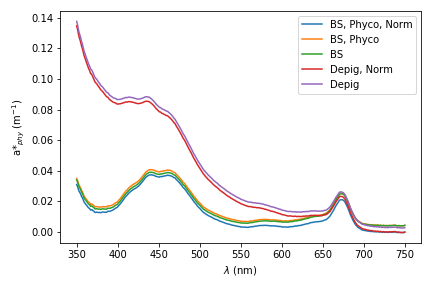

`calculate_instrument_led_correction` requires the following inputs:

- aphy: The chlorophyll specific phytoplankton absorption  
[`array`]
- ap_lambda: The wavelengths associated with aphy  
[`array`]
- method: Choose spectral correction method to either correct $\sigma$$_{PSII}$ or correct the background actinic light options include {'sigma','actinic'}  
[`str`]  
- e_background: For sigma spectral correction factor, select either insitu light (e.g. for underway or insitu measurements) or actinic light (e.g. for fluorescence light curves) as the background light source  
[`str`]  
- e_insitu: The in situ irradiance field, if None is passed then will theoretically calculated in situ light field if e_background is set to 'insitu'   
[`array`]
- chl: Chlorophyll concentration for estimation of K$_{bio}$ for theoretical in situ light field. If None is passed then chl is set to 1 mg/m3  
[`float`]
- e_actinic: Actinic light spectrum e.g. Spectra of the Actinic lights within the FastAct illuminating during Fluorescence Light Curves etc. Must defined for 'actinic' method  
[`str`]
- depth: The depth of the measurement. Must be set if theoretically calculating e_insitu  
[`float`]
- e_led: The excitation spectra of the instrument, options include {'fire','fasttracka_ii','fastocean'}  
[`str`]  
- wl: For FastOcean only. Select the excitation wavelength. Future PPU versions will provide option to mix LEDs. Options include {'450nm','530nm','624nm'}  
[`str`]

The spectra of the instrument is currently stored within the demo, the code can be updated to be more dynamic and allow users to insert their own measured excitation spectra.

In [ ]:
ppu.calculate_instrument_led_correction(aphy, pa_data.wavelength, e_led='fire')


## Extra Functions

### Fluorescence Light Curves

There is a function to calculate photosynthesis v irradiance parameters from fluorescence light curves; using either an e-dependent ETR method or an e-independent ETR method as per Silsbe & Kromkamp (2012). They use the model of Webb et al. (1974); future versions however could implement different models, i.e. Platt et al. (1980).

The functions require the following inputs:

- fo: the minimum fluorescence  
  [`numpy.array`]
- fm: the maximum fluorescence  
  [`numpy.array`]
- sigma: $\sigma$$_{PSII}$ in Å$^2$  
  [`numpy.array`]
- par: the actinic light levels  
  [`numpy.array`] 
- light_indepedent: if True, will use the Silsbe & Kromkamp method  
  [`bool`]
- light_step_size: the number of measurements for initial light step  
  [`int`]
- outlier_mutliplier: the multiplier to apply to the standard deviation for determining the upper and lower limits   
  [`int`]
- return_data: will return the final data used for the fit  
  [`bool`]
- bounds: if True, will set lower and upper limit bounds for the estimation, 
  not suitable for methods `lm`  
  [`bool`]
- alpha_lims: the lower and upper limit bounds for fitting $\alpha$  
  [`int`, `int`]
- etrmax_lims: the lower and upper limit bounds for fitting ETR$^\max$  
  [`int`, `int`]
  
The following are only applicable for the e-independent model when light_independent is True:
- dark_sigma: if True, will use mean of $\sigma$$_{PSII}$ under 0 actinic light for calculation. If False, will use $\sigma$$_{PSII}$ and $\sigma$$_{PSII}$' for calculation.   
  [`bool`]
  
The following options control the parameters of the least_squares fitting. They are derived from the `scipy.optimize.least_squares` function.

- fit_method: The algorithm to perform minimization  
[`str`]
- loss_method: The loss function to be used. Note: Method `lm` supports only `linear` loss  
[`str`]
- fscale: The soft margin value between inlier and outlier residuals  
[`float`]
- n_iter: The number of iterations to perform fitting routine  
[`int`]
- xtol: The tolerance for termination by the change of the independent variables  
[`float`]

See [scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) documentation for more information on non-linear least squares fitting options.

In [ ]:
# load in some example data to perform the FLC fitting routines
file = './data/raw/flc/flc_example.csv'
df = ppu.load_FastOcean_files(file, append=False, save_files=False, seq_len=125)

par = pd.read_csv(file, skiprows=30, nrows=1, header=None)
par = squeeze(par.iloc[:,2:].values)

df = ppu.fit_saturation(df.pfd, df.fyield, df.seq, df.datetime)

#### E-independent ETR

In [ ]:
etrmax, alpha, ek, bias, rmse, etrmax_err, alpha_err, data = ppu.calculate_etr(df.fo, df.fm, df.sigma, par, light_step_size=12, 
                  light_independent=True, return_data=True, dark_sigma=False, bounds=True, etrmax_lims=[0,1000])


Plotting the data

In [ ]:
sig = df.sigma[0:11].mean()
fig = ppu.plot_fluorescence_light_curve(data[0], data[1], etrmax=etrmax, alpha=alpha, rmse=rmse, sigma=sig, phi=True)

